### WGU D213 Advanced Data Analytics
# Task 1 - Time-Series Modeling

#### Ednalyn C. De Dios
#### August 28, 2023


# Environment

- Python: 3.9.9
- Jupyter: 7.0.2

# Part I. Research Question

## A1.  Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

> ### _What is the revenue forecast for the next quarter?_

## A2.  Define the objectives or goals of the data analysis. Ensure your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

Analyze two years' worth of daily revenue data of the organization and create a predictive model that will forecast the next 90 days of future revenue.

# Part II. Method Justification

## B. Summarize the assumptions of a time series model including stationarity and autocorrelated data.

Two assumptions of time series analysis include stationarity and autocorrelation. Stationarity means that "the mean, variance, and autocorrelation structure are constant over time" (Statisticssolutions.com, n.d.). In other words, "the statistical properties of a time series do not change over time" (Statisticssolutions.com, n.d.). The other assumption is no autocorrelation. "Autocorrelation occurs when future values in a time series linearly depend on past values" (Pierre, 2021).

## C1.  Provide a line graph visualizing the realization of the time series.

In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np
from datetime import datetime

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(style="whitegrid")
from IPython.display import Image

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from scipy import signal
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA

# to print out all the outputs of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# read the time series data set
df =  pd.read_csv('../data/teleco_time_series.csv')

In [3]:
df.head().T
df.tail().T

,0,1,2,3,4
Day,1.0,2.000000,3.000000,4.000000,5.000000
Revenue,0.0,0.000793,0.825542,0.320332,1.082554


,726,727,728,729,730
Day,727.000000,728.000000,729.000000,730.000000,731.000000
Revenue,16.931559,17.490666,16.803638,16.194813,16.620798


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


Text(0.5, 1.0, 'Revenue in Millions for Two Years')

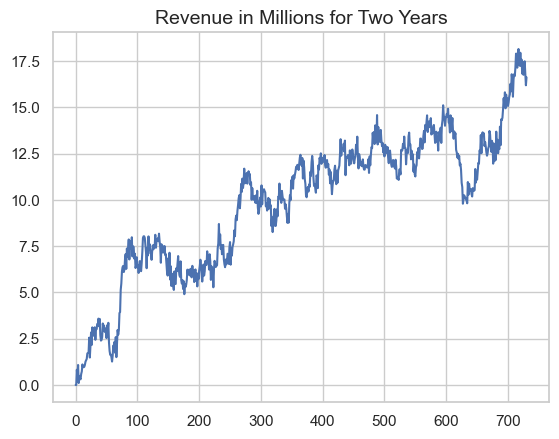

In [5]:
# plotting the realization of the time series
plt.plot(df.index, df['Revenue'])
plt.title('Revenue in Millions for Two Years', fontsize=14)

## C2.  Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.

tk

In [6]:
# drop zero values
df= df[df['Revenue'] != 0]

In [7]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Day,0,0.0,0,0.0,0,0.0
Revenue,0,0.0,0,0.0,0,0.0


In [8]:
# add Date column
df['Date'] = pd.date_range(start = datetime(2019,1,1),
                           periods = df.shape[0],
                           freq = '24H'
                          )

# set Date column as index
df.set_index('Date', inplace=True)
df.drop(columns=['Day'], inplace=True)

Text(0.5, 1.0, 'Revenue Chart')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Revenue in Millions $')

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628.]),
 [Text(17897.0, 0, '2019-01'),
  Text(17987.0, 0, '2019-04'),
  Text(18078.0, 0, '2019-07'),
  Text(18170.0, 0, '2019-10'),
  Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01')])

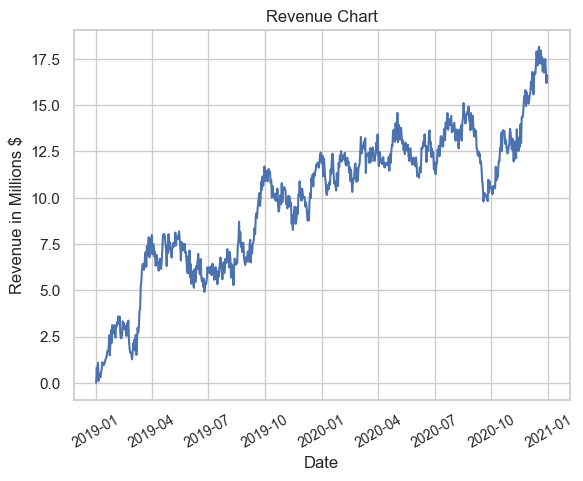

In [9]:
plt.plot(df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions $')
plt.xticks(rotation=30, fontsize=10)

## C3.  Evaluate the stationarity of the time series.

In [10]:
result = adfuller(df['Revenue'])
print('Test statistics: ', result[0])
print('P-value: ', result[1])
print('Critical value: ', result[4])
print('----------------------------------------------------------------------------------------------')

if result[1] >= 0.05:
    print('Reject the null hypothesis. The time series is stationary. No further action required.')
else:
    print('Fail to reject the null hypothesis. The time series is not stationary. You must make it so.')

Test statistics:  -1.7746383121968732
P-value:  0.3931237595029723
Critical value:  {'1%': -3.4393644334758475, '5%': -2.8655182850048306, '10%': -2.568888486973192}
----------------------------------------------------------------------------------------------
Reject the null hypothesis. The time series is stationary. No further action required.


## C4. Explain the steps you used to prepare the data for analysis, including the training and test set split.

tk

In [11]:
# use the last 30 days for testing
train = df.iloc[:-30]
test = df.iloc[-30:]
print('Training set: {}'.format(train.shape))
print('Testing set: {}'.format(test.shape))

Training set: (700, 1)
Testing set: (30, 1)


## C5. Provide a copy of the cleaned data set.

In [12]:
# save the cleaned data set
df.to_csv('../data/teleco_cleaned1.csv', index=False)
train.to_csv('../data/teleco_cleaned1_train.csv', index=False)
test.to_csv('../data/teleco_cleaned1_test.csv', index=False)

# Part IV. Model Identification and Analysis

## D1. Report the annotated findings with visualizations of your data analysis, including the following elements:

- the presence or lack of a seasonal component
- trends
- the autocorrelation function
- the spectral density
- the decomposed time series
- confirmation of the lack of trends in the residuals of the decomposed series

In [13]:
result = seasonal_decompose(df['Revenue'], model='multiplicable', period=12)

Text(0.5, 1.0, 'Seasonality')

<Axes: title={'center': 'Seasonality'}, xlabel='Date'>

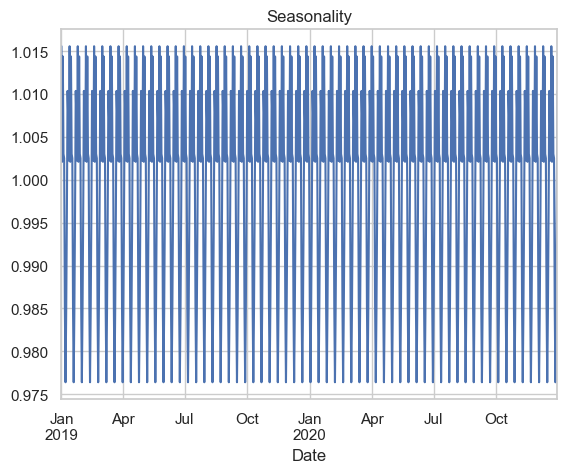

In [14]:
plt.title('Seasonality')
result.seasonal.plot()

Text(0.5, 1.0, 'Trend')

<Axes: title={'center': 'Trend'}, xlabel='Date'>

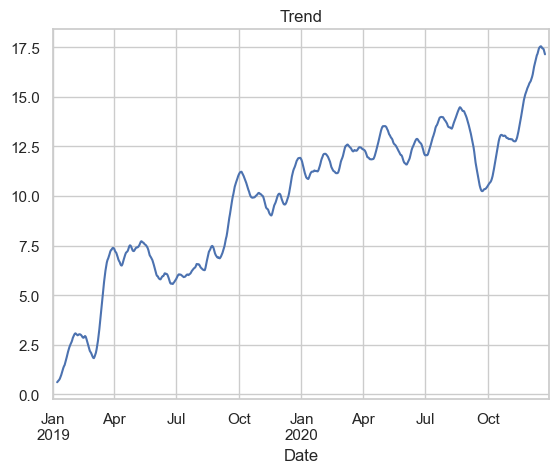

In [15]:
plt.title('Trend')
result.trend.plot()

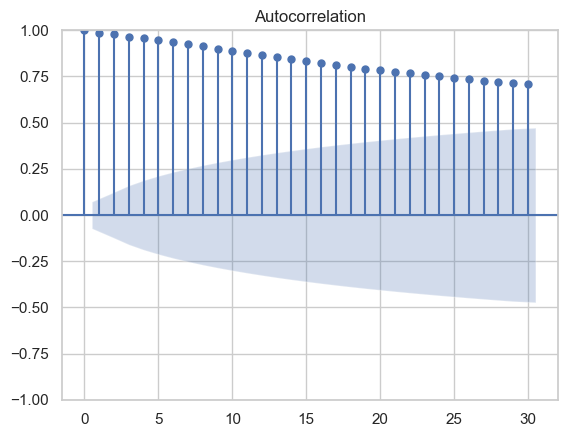

In [16]:
# calculate acf
acf_values = acf(df['Revenue'])

# keeping lag as 30
plot_acf(df['Revenue'], lags=30);

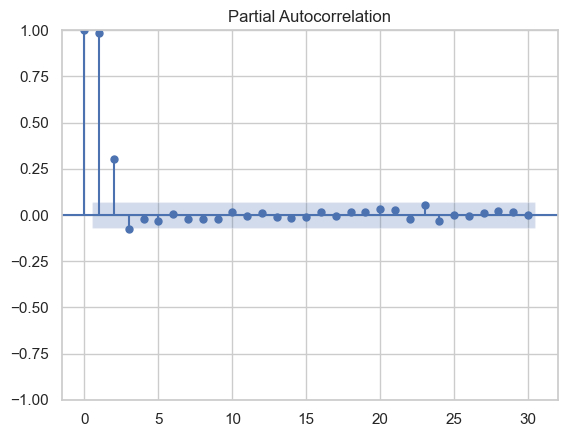

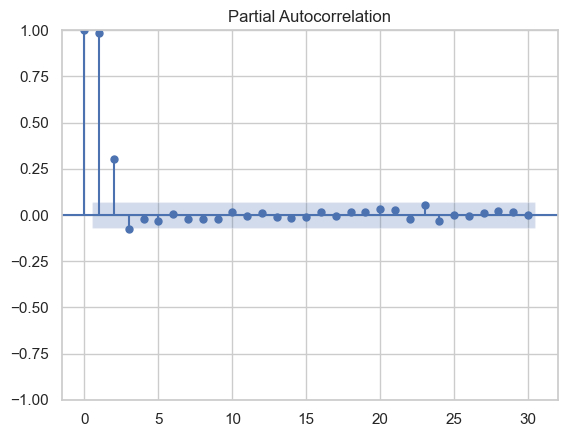

In [17]:
# PACF
pacf_values = (df['Revenue'])
 
# plot pacf
plot_pacf(df['Revenue'], lags=30)

(1e-06, 100.0)

Text(0.5, 1.0, 'Spectral Density')

Text(0.5, 0, 'Frequency')

Text(0, 0.5, 'Spectral Density')

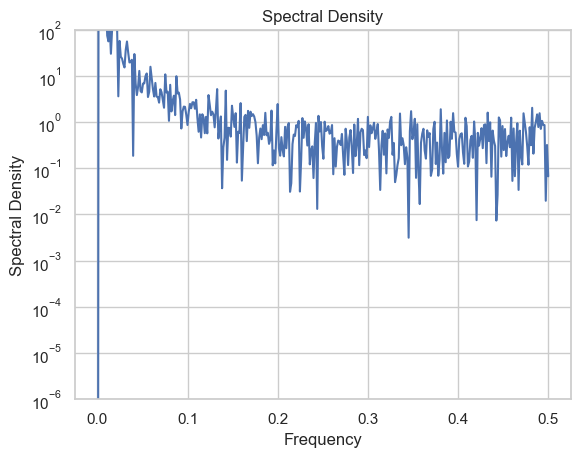

In [18]:
f, Pxx_den = signal.periodogram(df['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim(1e-6, 1e2)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')

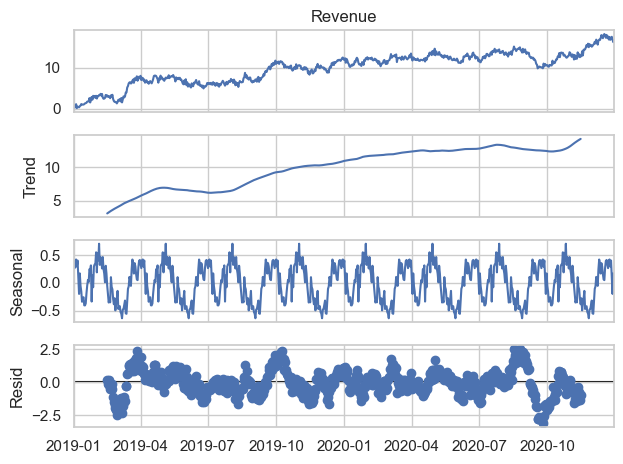

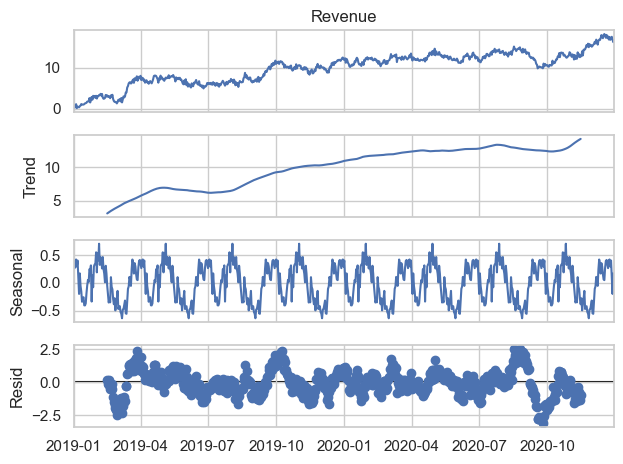

In [19]:
decomp = seasonal_decompose(df['Revenue'], period=90)
decomp.plot()

Text(0.5, 1.0, 'Residuals')

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

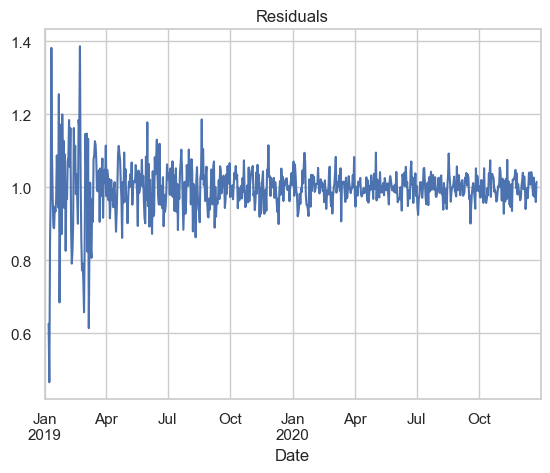

In [20]:
plt.title('Residuals')
result.resid.plot()

## D2. Identify an autoregressive integrated moving average (ARIMA) model that accounts for the observed trend and seasonality of the time series data.

In [21]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.02237291702715709, False)

In [22]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=493,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1550.191, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1200.240, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1394.111, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1086.815, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1053.850, Time=0.75 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1041.732, Time=1.48 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1026.291, Time=4.07 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=28.19 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=9.77 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1199.175, Time=2.79 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1028.127, Time=5.20 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=1028.161, Time=5.58 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=1065.220, Time=3.90 sec
 ARIMA(2,1,1)(5,1,0)[12]         

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  700
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -506.146
Date:                            Mon, 28 Aug 2023   AIC                           1026.291
Time:                                    19:25:58   BIC                           1058.017
Sample:                                01-01-2019   HQIC                          1038.566
                                     - 11-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4779      0.035    -13.760      0.000      -0.546      -0.410
ar.S.L12      -0.8505      0.039    -21.914      0.000      -0.927      -0.774
ar.S.L24      -0.7018      0.052    -13.424      0.000      -0.804      -0.599
ar.S.L36      -0.4564      0.059     -7.686      0.000      -0.573      -0.340
ar.S.L48      -0.2886      0.052     -5.526      0.000      -0.391      -0.186
ar.S.L60      -0.1658      0.040     -4.150      0.000      -0.244      -0.087
sigma2         0.2509      0.015     17.169      0.000       0.222       0.280
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.69
Prob(Q):                              0.87   Prob(JB):                         0.43
Heteroskedasticity (H):               1.05   Skew:                             0.03
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# create final model 
model = ARIMA(df['Revenue'], order=(1,1,0), seasonal_order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  730
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -489.851
Date:                Mon, 28 Aug 2023   AIC                            983.702
Time:                        19:27:42   BIC                            992.885
Sample:                    01-01-2019   HQIC                           987.245
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4682      0.033    -14.253      0.000      -0.533      -0.404
sigma2         0.2244      0.013     17.752      0.000       0.200       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.98   Prob(JB):                         0.35
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3. Perform a forecast using the derived ARIMA model identified in part D2.

In [36]:
df.tail()

,Revenue
Date,
2020-12-26,16.931559
2020-12-27,17.490666
2020-12-28,16.803638
2020-12-29,16.194813
2020-12-30,16.620798


In [44]:
# Train the model on the full dataset
model = model = ARIMA(df['Revenue'], 
                        order = (1, 1, 0), seasonal_order = (5, 1, 0))
model_fit = model.fit()

forecast = model_fit.predict(start = len(df), 
                          end = (len(df)-1) + 9 * 12).rename('Forecast')
  
# Plot the forecast values
df['Revenue'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

ValueError: `seasonal_order` argument must be an iterable with four elements.

In [45]:
test['Forecast'] = forecast
r2_score(test['Revenue'], test['Forecast'])

# R2 Score for test data set

ValueError: Input contains NaN.

## D4. Provide the output and calculations of the analysis you performed.

Filename: "D213 Performance Assessment Task 1 (Rev. 0).ipynb"

## D5. Provide the code used to support the implementation of the time series model.

Filename: "D213 Performance Assessment Task 1 (Rev. 0).ipynb"

# Part V. Data Summary and Implications

## E1. Discuss the results of your data analysis, including the following points:

- the selection of an ARIMA model
- the prediction interval of the forecast
- a justification of the forecast length
- the model evaluation procedure and error metric

The final ARIMA model was based on the results of Auto ARIMA (Best model:  ARIMA(1,1,0)(5,1,0)[12]) which takes into account the trend and seasonality of the data set. The prediction interval of the forecast is 30 days and can be made using the .predict() or .forecast() methods. Forecast length of 180 is enough information to make changes in preparation for the next quarter or so. The final model was evaluated with R2. It "measures the strength of the relationship between your model and the dependent variable" (Frost, 2018). Although 52.83 is a relatively low result, a low R2 doesn't necessarily mean the model is bad (Frost, 2018).

## E2. Provide an annotated visualization of the forecast of the final model compared to the test set.

In [ ]:
plt.plot(test.index, test, label='Observed')
plt.plot(mean_prediction.index, mean_prediction, color='r', label='Forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('Forecast comparing with test data')
plt.xlabel('Date')
plt.ylabel('Revenue in Million $')
plt.xticks(rotation=30, fontsize=10)
plt.legend()

## E3. Recommend a course of action based on your results.

The forecast data estimates that revenue will be at $16.48 million. Visual inspection of the plot also reveals a downward trend for the forecasted quarter. As such, I recommend a conservative approach to configuring organization operations for this quarter.

# Part VI. Reporting

## F. With the information from part E, create your report using an industry-relevant interactive development environment (e.g., an R Markdown document, a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

Filename: "D213 Performance Assessment Task 1 (Rev. 0).pdf"

## G. Cite the web sources you used to acquire third-party code to support the application.

- https://github.com/ecdedios/code-snippets/blob/main/notebooks/master.ipynb
- https://www.datacamp.com/tutorial/matplotlib-time-series-line-plot
- https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861
- https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2
- https://analyticsindiamag.com/what-are-autocorrelation-and-partial-autocorrelation-in-time-series-data/
- https://github.com/mkosaka1/AirPassengers_TimeSeries/blob/master/Time_Series.ipynb

## H. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

- https://www.statisticssolutions.com/stationary-data-assumption-in-time-series-analysis/
- https://builtin.com/data-science/time-series-python
- https://statisticsbyjim.com/regression/interpret-r-squared-regression/

In [ ]:
print('Succesful run!')